In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline


#### 1. Have a quick look at data

In [108]:
dfa = pd.read_csv('./data/data_a.txt', header=None, sep=' ', names=['label', 'x1', 'x2'])

<AxesSubplot:xlabel='x1', ylabel='x2'>

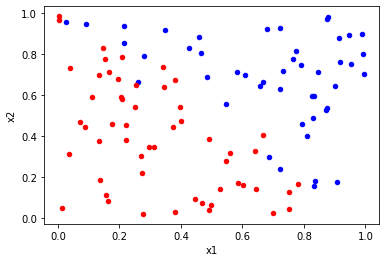

In [109]:
ax = plt.axes()
dfa.query('label == 1').plot.scatter(x='x1', ax= ax, y='x2', color="blue")
dfa.query("label == -1").plot.scatter(x='x1', ax = ax, y='x2', color = "red")

In [110]:
dfb = pd.read_csv('./data/data_b.txt', header = None, sep =' ', names=['label', 'x1', 'x2'])

<AxesSubplot:xlabel='x1', ylabel='x2'>

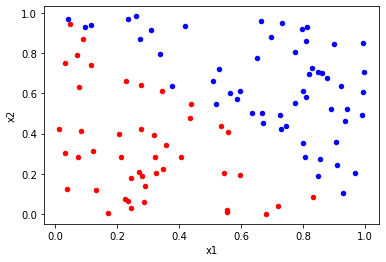

In [111]:
ax = plt.axes()
dfb.query('label == 1').plot.scatter(x="x1", y="x2", ax=ax, color = "blue")
dfb.query('label == -1').plot.scatter(x="x1",y="x2", ax=ax, color ='red')

#### 2. Debug for the Logistic regression

In [151]:
def add_intercept(X_):
    m, n = X_.shape
    X = np.zeros((m, n + 1))
    X[:, 0] = 1
    X[:, 1:] = X_
    return X

def load_data(filename):
    D = np.loadtxt(filename)
    Y = D[:, 0]
    X = D[:, 1:]
    return add_intercept(X), Y

def calc_grad(X, Y, theta):
    m, n = X.shape # m is the number of trainning examples, n is the number of featrues
    grad = np.zeros(theta.shape) # n×1

    margins = Y * X.dot(theta)  # m×1
    probs = 1. / (1 + np.exp(margins))  #m×1 
    grad = - (1./m) * (X.T.dot(probs * Y)) #n×1 ?? why divided by m when this is SGD.

    return grad


def logloss(X, Y, theta):
    Y_copy = Y.copy()
    Y_copy[Y_copy == -1] = 0
    pred_probs = 1 / (1 + np.exp(- X.dot(theta)))
    epsilon = 1e-16
    return - np.sum(Y_copy * np.log(pred_probs + epsilon) + (1 - Y_copy) * np.log(1 - pred_probs + epsilon))
    

def logistic_regression(X, Y):
    m, n = X.shape
    theta = np.zeros(n)
    learning_rate = 10

    i = 0
    thetas = []
    errors = []
    while True:
        i += 1
        prev_theta = theta
        grad = calc_grad(X, Y, theta)
        theta = theta  - learning_rate * (grad)
        if i % 10000 == 0:
            print('Finished {0} iterations; logloss: {1}'.format(i, logloss(X, Y, theta)))
            thetas.append(theta)
        error = np.linalg.norm(prev_theta - theta)
        errors.append(error)
        if error < 1e-15:
            print('Converged in %d iterations' % i)
            break
        if i == 5 * 10000:
            break
    return thetas, errors

#### 2.1 data_a

In [152]:
X_a, Y_a = load_data('./data/data_a.txt')
tha, erra = logistic_regression(X_a, Y_a)


Finished 10000 iterations; logloss: 15.98874822112764
Finished 20000 iterations; logloss: 15.98874821838721
Finished 30000 iterations; logloss: 15.98874821838721
Converged in 30370 iterations


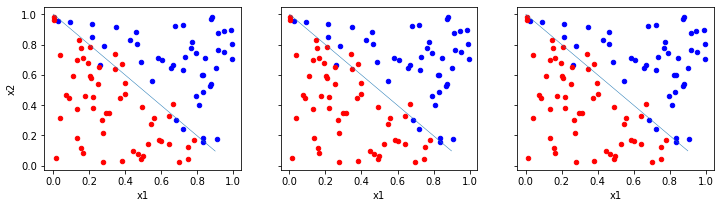

In [153]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 3))
axes = axes.ravel()

for k, theta in enumerate(thetas[:3]):
    ax = axes[k]
    xs = np.arange(0, 1, 0.1)
    ys = (-theta[0] - theta[1] * xs) / theta[2]
    ax.plot(xs, ys, lw=0.5)
    dfa.query('label ==  1').plot.scatter(x='x1', y='x2', ax=ax, color='blue')
    dfa.query('label == -1').plot.scatter(x='x1', y='x2', ax=ax, color='red')

#### 2.1 data_b

In [154]:
X_b, Y_b = load_data('./data/data_b.txt')

In [155]:
X_b, Y_b = load_data('./data/data_b.txt')
thetas, errors = logistic_regression(X_b, Y_b)


Finished 10000 iterations; logloss: 3.0450922247585837
Finished 20000 iterations; logloss: 2.325567062726741
Finished 30000 iterations; logloss: 1.9655254432929155
Finished 40000 iterations; logloss: 1.7379713038351363
Finished 50000 iterations; logloss: 1.5770732018729932


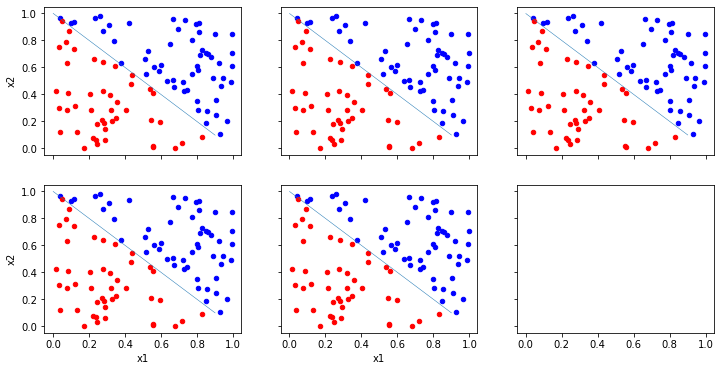

In [156]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 6))
axes = axes.ravel()

for k, theta in enumerate(thetas[:5]):
    ax = axes[k]
    xs = np.arange(0, 1, 0.1)
    ys = (-theta[0] - theta[1] * xs) / theta[2]
    ax.plot(xs, ys, lw=0.5)
    dfb.query('label ==  1').plot.scatter(x='x1', y='x2', ax=ax, color='blue')
    dfb.query('label == -1').plot.scatter(x='x1', y='x2', ax=ax, color='red')

#### Why data_b takes so long for LR to converge? 
1. Because of data_b's perfect linearly separability (even at the early stage), so the algorithm is just trying to increase the scale of theta, i.e.increase $|\theta^Tx|$, which would lead to higher probability, hence higher likelihood.
2. In the case of perfect separation, the theorectical maximum likelihood is 1, so untill theta reaches infinity, won't the algorithm stop. 
3. Also, because of its gradient descent, so the amount of change is decreasing


This doesn't happen to A because it's not linearly separable.

#### State whether or not it would lead to the provided training algorithm converging on datasets such as B


i. Using a different constant learning rate.

**Ans:** No, as the $\theta$ still needs to go to infinite to make maximum likelihood. However, it's may reach the numeric infinite (e.g. 1e15) faster if the learning rate is huge.

ii. Decreasing the learning rate over time (e.g. scaling the initial learning rate by $1/t^2$, where $t$ is the number of gradient descent iterations thus far).

**Ans:** No, this is not a problem caused by learning rate being too big.

iii. <mark> Adding a regularization term $\left|\left|\theta\right|\right|^2_2$ to the loss function. </mark>

**Ans:** Yes, thus $\theta$ won't be scaled to infinitely large.

iv. Linear scaling of the input features.

**Ans:** No, scaling input features is irrelevant to $\theta$ getting infinitely large.

v. <mark> Adding zero-mean Gaussian noise to the training data or labels </mark>

**Ans:** Yes, Adding Gaussian noise may make the training data imperfectly separable with a linear classifier. 